# My first neural network!
## ICE 2025 - Artificial Intelligence for O&G Without the Hype

>  - Complete: <a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/torch_MLP_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
>
>  - Class: <a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/torch_MLP_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Pedro Pesce <<pedro_pesce@petrobras.com.br>>
- Thiago Toribio <<thiago.toribio@petrobras.com.br>>
- Cesar Calderon <<cjcalderon@petrobras.com.br>>
- Luiz Eduardo Queiroz <<eduardoqueiroz@petrobras.com.br>>
- Antonio de Padua Pires <<antonio.pires@petrobras.com.br>>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets as skdata
import sklearn.model_selection as skms
import sklearn.metrics as skm

import seaborn as sns
import time

import torch
from torch import nn
from torch import optim

# Checking if we have a GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'{torch.version.cuda = }')
    
else:
    device = torch.device('cpu')

print(device)

torch.version.cuda = '12.8'
cuda


## Loading the data

The DIGITS dataset is available through `sklearn.datasets`:

In [2]:
# Loading the data from DIGITS

digits = skdata.load_digits()

X = torch.tensor(digits.data,device=device,dtype=torch.float)
y = torch.tensor(digits.target,device=device,dtype=torch.long)

# Splitting data into training and validation
X_train, X_validation, y_train, y_validation = skms.train_test_split(X,y,train_size=0.7,random_state=42)

# Checking the size of the training and validation data
print(f'{X_train.shape      = } ; {X_train.dtype} ; {X_train.device}')
print(f'{y_train.shape      = } ; {y_train.dtype} ; {y_train.device}')
print(f'{X_validation.shape = } ; {X_validation.dtype} ; {X_validation.device}')
print(f'{y_validation.shape = } ; {y_validation.dtype} ; {y_validation.device}')

X_train.shape      = torch.Size([1257, 64]) ; torch.float32 ; cuda:0
y_train.shape      = torch.Size([1257]) ; torch.int64 ; cuda:0
X_validation.shape = torch.Size([540, 64]) ; torch.float32 ; cuda:0
y_validation.shape = torch.Size([540]) ; torch.int64 ; cuda:0


### Visualizing some examples

Notice how each row of the dataset is simply a list of 64 features. We can choose to interpret it as an $(8,8)$ image, but nothing in the dataset indicates the spatial relationship between neighboring pixels. More advanced neural network architectures, such as *convolutional neural networks* make use of this spatial relationship to improve performance.

0.0 ; 0.0 ; 12.0 ; 16.0 ; 16.0 ; 8.0 ; 0.0 ; 0.0 ; 0.0 ; 3.0 ; 16.0 ; 13.0 ; 8.0 ; 5.0 ; 0.0 ; 0.0 ; 0.0 ; 2.0 ; 16.0 ; 3.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 16.0 ; 13.0 ; 9.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 10.0 ; 16.0 ; 16.0 ; 7.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 1.0 ; 10.0 ; 13.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 2.0 ; 11.0 ; 16.0 ; 10.0 ; 0.0 ; 0.0 ; 0.0 ; 0.0 ; 11.0 ; 16.0 ; 12.0 ; 0.0 ; 0.0 ; 0.0


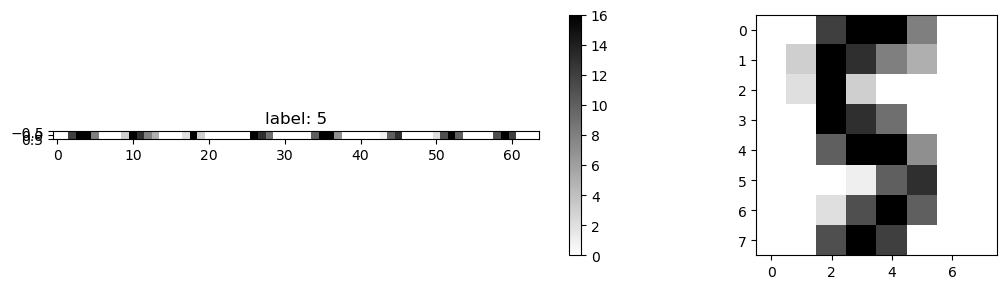

tensor([[ 0.,  0., 12., 16., 16.,  8.,  0.,  0.],
        [ 0.,  3., 16., 13.,  8.,  5.,  0.,  0.],
        [ 0.,  2., 16.,  3.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 16., 13.,  9.,  0.,  0.,  0.],
        [ 0.,  0., 10., 16., 16.,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  1., 10., 13.,  0.,  0.],
        [ 0.,  0.,  2., 11., 16., 10.,  0.,  0.],
        [ 0.,  0., 11., 16., 12.,  0.,  0.,  0.]], device='cuda:0')

In [3]:
# Plot of some examples

ind = 102 # YOUR CODE HERE Choose an example to visualize
example = X[ind]

example = example + 0*torch.randn_like(example) # Add some noise?

print(*[round(it.item(),1) for it in example], sep=' ; ')
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,3))
CS = ax0.imshow(example.cpu().reshape(1,-1),cmap='gray_r')
ax0.set_title(f'label: {y[ind]}')
plt.colorbar(CS,ax=ax0)
CS = ax1.imshow(example.cpu().reshape(8,8), cmap='gray_r')
plt.tight_layout()
plt.show()

display(example.reshape(8,8))

### Creating the model


While we do not know precisely how pixel intensities can be mapped to the number an image represents, there is certainly a **functional relation** between an input image and its number. We will make use of the fact that a sufficiently complex neural network is a **universal approximator** to obtain a model that uses pixel intensities (64 **features**) to estimate the probability of each example belonging to one of 10 possible classes.

The simplest architecture for a neural network is the so-called **Fully-Connected Neural Network** (FCNN), sometimes called a **Multi-Layer Perceptron** (MLP). There are several possibilities for hyperparameter tuning of this type of network, including the number of hidden layers (the network's **depth**), the number of neurons per layer (its **width**), choice of **activation functions**, normalization, regularization, etc.

In this notebook, we will use a single hidden layer with 100 neurons and a **ReLU** activation function, followed by another linear layer and a **softmax** probability normalization, as illustrated below.

<center><img src="https://github.com/paduapires/aapg_ice/blob/main/MLP.png?raw=1" align="center" width="40%"></center>

$$
{\color{blue}{X}} {\color{red}{W^{(1)}}} + {\color{red}{B^{(1)}}} = H^{(1)} \quad ; \quad
ReLU(H^{(1)}) = A^{(1)} \quad ; \quad
A^{(1)} {\color{ red }{ W^{(2)}}}+ {\color{red}{B^{(2)}}} = H^{(2)} \quad ; \quad
softmax(H^{(2)}) = {\color{purple}{P}}
$$

$$
{\color{purple}{P}} = softmax\Biggl(\underbrace{ \underbrace{ReLU\bigl(\underbrace{ {\color{blue}{X}} {\color{red}{W^{(1)}}} + {\color{red}{B^{(1)}}} }_{H^{(1)}}\bigr)}_{A^{(1)}}
{\color{red}{W^{(2)}}}+ {\color{red}{B^{(2)}}}}_{H^{(2)}}\Biggr)
$$

where:

- $\color{blue}{X}$ is the data matrix, with $N$ rows (one for each example) and $64$ columns (one for each **feature**). It represents the model's <span style="color:blue">**inputs**</span>;
- ${\color{red}{W^{(1)}}}$, ${\color{red}{B^{(1)}}}$, ${\color{red} {W^{(2)}}}$, ${\color{red}{B^{(2)}}}$ are the adjustable <span style="color:red">**parameters**</span> of the network (**weights** and **biases**), which we optimize based on some loss function in order to solve the proposed problem;
- $H^{(1)}, A^{(1)}, H^{(2)}$ are intermediate values computed by the network. They are hidden, or **latent** values. $H^{(2)}$ in particular, being the inputs to the final softmax normalization, are also called the network's **logits**;
- $\displaystyle{ ReLU\Bigl(h_{ij}^{(1)}\Bigr) = max(0,h_{ij}^{(1)}) = \begin{cases} h_{ij}^{(1)}&, h_{ij}^{(1)}\geq 0 \\ 0&, h_{ij}^{(1)}\le 0 \end{cases} \, \, }$  is the **activation function** chosen for the hidden layer, which operates element-wise;
- $\displaystyle{ softmax\Bigl(h^{(2)}_{ij}\Bigr) = \dfrac{e^{h^{(2)}_{ij}}}{\displaystyle \sum_je^{h^{(2)}_{ij}}} }$ is the final **activation function**, which normalizes each row of **logits** and outputs the probabilities matrix the ${\color{purple}{P}}$, such that all output probabilities are positive and sum to $1$ for each example. This is a generalization of the sigmoid function;
- Each element ${\color{purple}{p_{ij}}}$ of the network output is the estimated probability that example $i$ belongs to class $j$.

Pytorch implements these operations with `nn.Linear` and `nn.ReLU`, which can be applied sequentially by placing them inside an `nn.Sequential` object. During training, the network should output the final **logits**, and **not** the **probabilities**, for efficiency and stability. The final `torch.softmax` normalization **must not** be a part of the network, but can be applied at a later time if so desired.

In [4]:
torch.manual_seed(13)
size_input = X.shape[1]  # YOUR CODE HERE for the number of input features
size_H = 100  # YOUR CODE HERE for the hidden layer size
size_output = 10 # YOUR CODE HERE for the number of classes

mlp = nn.Sequential(nn.Linear(size_input,size_H), 
                    nn.ReLU(),         
                    nn.Linear(size_H,size_output)).to(device=device)
mlp

Sequential(
  (0): Linear(in_features=64, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

## Parameter initialization

Each linear layer has a weight matrix $W$ and a bias vector $B$, known as the parameters of the network. These parameters are typically initialized with small random values, according to various heuristics. We will use the default behavior of PyTorch, with weights randomly and uniformly distributed in the interval $\left(\dfrac{-1}{\sqrt{N_{\text{inputs}}}}, \dfrac{1}{\sqrt{N_{\text{inputs}}}}\right)$, where $N_{\textrm{inputs}}$ is the number of input features *for that specific layer*.

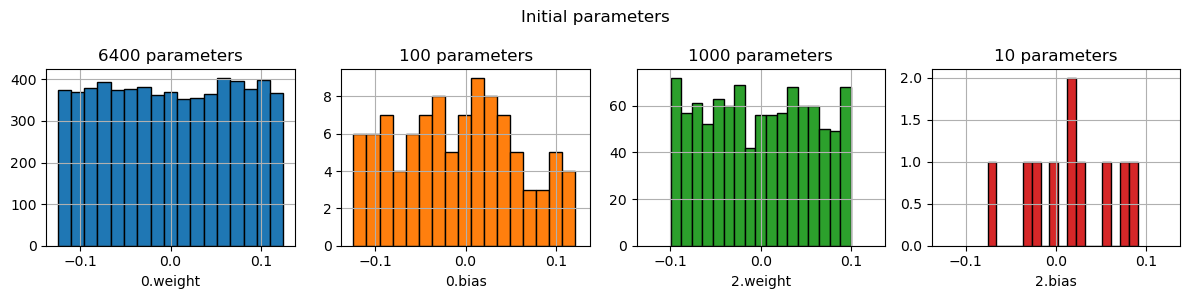

In [5]:
fig,axs = plt.subplots(1,4,sharex='all',figsize=(12,3))

for i,((par_name,par),ax) in enumerate(zip(mlp.named_parameters(),axs.flat)):
    ax.hist(par.cpu().detach().ravel(),bins=17,color='C'+str(i),edgecolor='k')
    ax.set_title(f'{par.numel()} parameters')
    ax.set_xlabel(par_name)
    ax.grid()
fig.suptitle('Initial parameters')
fig.tight_layout()

### Objective function

For classification problems, **categorical cross-entropy** is the most commonly used objective function.

$$
L = \textrm{x-entropy}\bigl({\color{purple}{P}},Y\bigr) = -\dfrac{1}{N_{\text{examples}}} \sum_i^{N_{\text{examples}}} \sum_j^{N_{\text{classes}}} y_{ij} \ln\left({\color{purple}{p_{ij}}}\right)
$$

where $y_{ij}$ is $1$ if example $i$ belongs to class $j$, and $0$ otherwise.

This is equivalent to taking the average of $-\ln({\color{purple}{p_{ij}}})$ only over the probabilities estimated by the model for the example's true class. This is a generalization of the previously studied binary cross-entropy function.

Note that Pytorch's implementation of `nn.CrossEntropyLoss` expects the inputs to be the unnormalized logits for each class (which do not need to be positive or sum to 1), allowing for more efficient gradient computation.

In [6]:
# Creating the loss function (cross-entropy - classification)
cross_entropy = nn.CrossEntropyLoss().to(device) # place in the same device as the model

### Optimization

In order to train the neural network, we compute the gradient of the **objective function** with respect to each of the network's <span style="color:red">**parameters**</span>, that is:

$$
\frac{\partial L}{\partial {\color{red}{W^{(1)}}}} \, ; \,
\frac{\partial L}{\partial {\color{red}{B^{(1)}}}} \, ; \,
\frac{\partial L}{\partial {\color{red}{W^{(2)}}}} \, ; \,
\frac{\partial L}{\partial {\color{red}{B^{(2)}}}}
$$

These matrix derivatives are arranged in the same shape as the parameters in relation to which the derivative is calculated, that is, $\dfrac{\partial L}{\partial {\color{red}{W^{(1)}}}}$ is the same shape as ${\color{red}{W^{(1)}}}$,  $\dfrac{\partial L}{\partial {\color{red}{B^{(1)}}}}$ is the same shape as ${\color{red}{B^{(1)}}}$, etc. 

The chain rule allows us to obtain theses values:

$$
{\color{blue}{X}} {\color{red}{W^{(1)}}} + {\color{red}{B^{(1)}}} = H^{(1)} \quad ; \quad
ReLU(H^{(1)}) = A^{(1)} \quad ; \quad
A^{(1)} {\color{ red }{ W^{(2)}}}+ {\color{red}{B^{(2)}}} = H^{(2)} \quad ; \quad
softmax(H^{(2)}) = {\color{purple}{P}}
$$

$$
L = \textrm{x-entropy}\Biggl(\underbrace{softmax\biggl(\underbrace{ \underbrace{ReLU\bigl(\underbrace{ {\color{blue}{X}} {\color{red}{W^{(1)}}}+ {\color{red} {B^{(1)}}}}_{H^{(1)}}\bigr)}_{A^{(1)}}
{\color{red} {W^{(2)}}}+ {\color{red}{B^{(2)}}} }_{H^{(2)}}\biggr)}_{ {\color{purple} {P}} },Y\Biggr)
$$

$$\begin{align}
\frac{\partial L}{\partial H^{(2)}} &= \underbrace{ {\color{purple}{P}}-Y}_{\textrm{error}} \\
\frac{\partial L}{\partial {\color{red}{B^{(2)}}}} &= \frac{\partial L}{\partial H^{(2)}} \underbrace{\frac{\partial H^{(2)}}{\partial {\color{red}{B^{(2)}}}}}_{1} \quad ; &
\frac{\partial L}{\partial {\color{red}{W^{(2)}}}} &= \frac{\partial L}{\partial H^{(2)}} \underbrace{\frac{\partial H^{(2)}}{\partial {\color{red}{W^{(2)}} } }}_{A^{(1)}} \\
\frac{\partial L}{\partial A^{(1)}} &= \frac{\partial L}{\partial H^{(2)}} \underbrace{\frac{\partial H^{(2)}}{\partial A^{(1)}}}_{ {\color{red}{W^{(2)}} }^T} \\
\frac{\partial L}{\partial H^{(1)}} &= \frac{\partial L}{\partial A^{(1)}} \underbrace{\frac{\partial A^{(1)}}{\partial H^{(1)}}}_{u(H^{(1)})} \quad ; &  
u\Bigl(h_{ij}^{(1)}\Bigr) &= \begin{cases} 1 &, h_{ij}^{(1)}\gt 0 \\ 0&, h_{ij}^{(1)}\le 0 \end{cases}  \\
\frac{\partial L}{\partial {\color{red}{B^{(1)}}}} &=
\underbrace{
    \frac{\partial L}{\partial H^{(2)}} \frac{\partial H^{(2)}}{\partial A^{(1)}}  \frac{\partial A^{(1)}}{\partial H^{(1)}}
           }_{\frac{\partial L}{\partial H^{(1)}}} \, \underbrace{\frac{\partial H^{(1)}}{\partial { \color{red}{B^{(1)}} } }}_{1}
\quad ;&
\frac{\partial L}{\partial {\color{red}{W^{(1)}}}} &=
\underbrace{
    \frac{\partial L}{\partial H^{(2)}} \frac{\partial H^{(2)}}{\partial A^{(1)}}  \frac{\partial A^{(1)}}{\partial H^{(1)}}
           }_{\frac{\partial L}{\partial H^{(1)}}} \,  \underbrace{\frac{\partial H^{(1)}}{\partial {\color{red}{W^{(1)}}}}}_{ {\color{blue}X}}
\end{align}
$$

where for simplicity we omitted the fact that some of these products are matrix products, some are outer products and some are element-wise products. For a more step-by-step derivation of these results, see [https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf].

These gradients will be calculated automatically with Pytorch's **autograd** functionality.

### Autograd

It's important to note that the efficient operationalization of the chain rule in neural networks to calculate the gradients, known as **backpropagation** (term coined in the 80's by Rumelhart et al, inspired by a work of Rosenblatt), was essential for the training of larger scale neural networks to be feasible. 

PyTorch's autograd system builds a computational graph for operations with tensors that have set `requires_grad=True` (such as is done automatically for `nn.Sequential` parameters), and then traverses this graph during a `.backward()` call to compute gradients for the leaf tensors using the chain rule. After a `.backward()` call, the gradient values can be accessed via `tensor.grad`.

As an example, let's create a simple scalar expression $S$ and obtain its gradient:

$$
\begin{align}
S & = \frac{e^{xw+b}}{1+e^{xw+b}} \\
\frac{\partial S}{\partial b} &= \frac{e^{xw+b}\left(1+e^{xw+b} \right)\phantom{x} - e^{xw+b}e^{xw+b}\phantom{x}}{\left(1+e^{xw+b}\right)^2}= \phantom{x}S-S^2\phantom{x} =S(1-S)\\
\frac{\partial S}{\partial w} &= \frac{e^{xw+b}x\left(1+e^{xw+b} \right) - e^{xw+b}e^{xw+b}x}{\left(1+e^{xw+b}\right)^2}= Sx-S^2x = S(1-S)x
\end{align}
$$

where $b,w,x$ can take on any scalar values.

In [7]:
w = torch.tensor(1.,requires_grad=True) # must be float, requires_grad=True
b = torch.tensor(2.,requires_grad=True) # must be float, requires_grad=True
x = torch.tensor(3.) # not a parameter, no need for grad

S = torch.exp(x*w+b)/(1+torch.exp(x*w+b)) # YOUR CODE HERE to obtain S (forward pass)

S.backward() # YOUR CODE HERE to calculate the gradients of S with respect to its inputs (backpropagation)

print(f'{b.grad = } ; Manual computation: {S*(1-S)}')
print(f'{w.grad = } ; Manual computation: {S*(1-S)*x}')
print(f'{x.grad = } ; Does not calculate, since requires_grad=False')


b.grad = tensor(0.0066) ; Manual computation: 0.0066480329260230064
w.grad = tensor(0.0199) ; Manual computation: 0.019944097846746445
x.grad = None ; Does not calculate, since requires_grad=False


### Optimizer

There are many different optimization strategies, most of which are variations of the basic gradient descent algorithm, which is available via `optim.SGD`. 

Optimizers update a model's parameters whenever the `.step()` method is called. Parameter updates can be done with different frequencies:
- Once for every example: **Stochastic Gradient Descent** (SGD), or **online** gradient descent;
- Once every `n_batch` examples: **mini-batch gradient descent**, frequently (but incorrectly) called **Stochastic Gradient Descent** (SGD);
- Once per epoch:  (classical, **batch** or **full-batch**) gradient descent.

While **full-batch** gradient descent performs only one (computationally expensive) update per **epoch** (one complete pass through all training examples), stochastic and mini-batch gradient descent allow for several (computationally cheaper, but noisy) parameter updates per **epoch**, usually achieving faster training times.

In this example, we will use a learning rate of `lr=0.04`.

In [8]:
optimizer = optim.SGD( mlp.parameters(), lr = 0.04) # YOUR CODE HERE to set the optimizer's hyperparameters

### Learning Loop (Optimization)

The process of searching for **optimum values** for the **weights** and **biases** occurs in the learning loop. This consists of some basic steps:

> 1) **Forward** stage:
> > - Computation of the estimated **outputs** for a set of inputs
> > - Computation of the **loss** function
> 2) **Backward** stage:
> > - Computation of the **gradient** of the loss function with respect to each weight and bias
> 3) **Learning** stage:
> > - **Update** of weights and biases



In [9]:
# Initializing empty lists
loss_train_vanilla = []
loss_train_augmented = []
loss_validation  = []

epoch = 0

In [10]:
data_augmentation = False # add noise to training examples?
batches = 1 # full-batch (1) or mini-batch (6, for example)

start = time.time()
max_epochs = 150
n_batch = int(np.ceil(X_train.shape[0]/batches))
for i_epoch in range(1,max_epochs+1):
    l_vanilla = 0 # initializing for the epoch
    l_augmented = 0
    for ind in range(0,X_train.shape[0],n_batch): # mini batches
        X_batch = X_train[ind:ind+n_batch]
        y_batch = y_train[ind:ind+n_batch]

        # 1) Forward pass
        logits_pred = mlp(X_batch) # computes the predicted logits (and likely errs)
        loss = cross_entropy(logits_pred,y_batch) # computes the loss function
        l_vanilla += loss.item() # stores simple float value for later plot

        if data_augmentation:
            X_augmented = X_batch + 3.0*torch.randn_like(X_batch) # Data augmentation?
            logits_pred = mlp(X_augmented) # adding noise (data augmentation)
            loss = cross_entropy( logits_pred,y_batch) # If data augmentation, will calculate grad with this value
            l_augmented += loss.item() # stores simple float value  for later plot

        # 2) Backward pass: calculating the gradients
        optimizer.zero_grad() # ensure all gradients are reset, instead of adding to previous values
        loss.backward()

        # 3) Updating the parameters
        optimizer.step()
        
    loss_train_vanilla.append(l_vanilla/batches) # Saving for posterity
    loss_train_augmented.append(l_augmented/batches) # Saving for posterity

    # Checking the performance on the validation set
    with torch.no_grad(): # no need for gradients here. Saves some computation cost
        logits_pred = mlp(X_validation)
        l_validation = cross_entropy(logits_pred, y_validation)
        loss_validation.append(l_validation.item())
    if ((epoch+i_epoch)%(min(max_epochs//5,500))) == 0 or i_epoch in [1,max_epochs]:
        end = time.time()
        t = end-start
        print(f'Epoch {epoch+i_epoch:4d}: Loss Train augmented {loss_train_augmented[-1]:.5f}; Loss Train vanilla {loss_train_vanilla[-1]:.5f}; Loss Validation {loss_validation[-1]:.5f}; Time {t:.5f}s')
        start = time.time()
epoch += max_epochs

Epoch    1: Loss Train augmented 0.00000; Loss Train vanilla 3.51306; Loss Validation 3.64808; Time 0.21337s
Epoch   30: Loss Train augmented 0.00000; Loss Train vanilla 0.27188; Loss Validation 0.28903; Time 0.08669s
Epoch   60: Loss Train augmented 0.00000; Loss Train vanilla 0.13562; Loss Validation 0.16629; Time 0.08439s
Epoch   90: Loss Train augmented 0.00000; Loss Train vanilla 0.09878; Loss Validation 0.13719; Time 0.09993s
Epoch  120: Loss Train augmented 0.00000; Loss Train vanilla 0.07756; Loss Validation 0.12197; Time 0.09362s
Epoch  150: Loss Train augmented 0.00000; Loss Train vanilla 0.06320; Loss Validation 0.11226; Time 0.09696s


### Visualizing the training progress

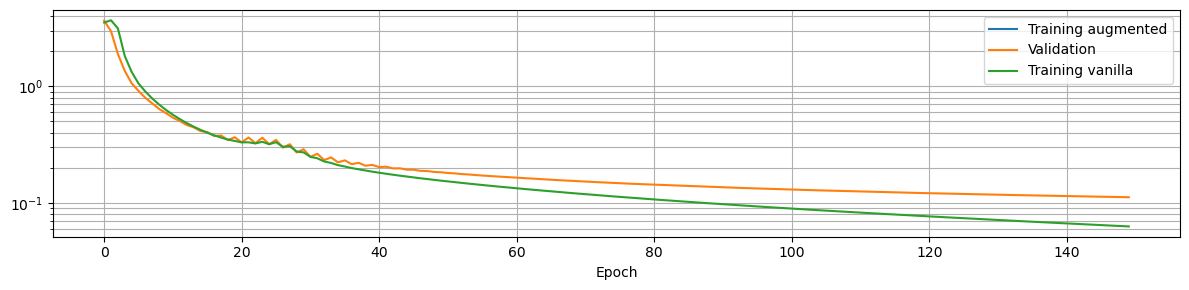

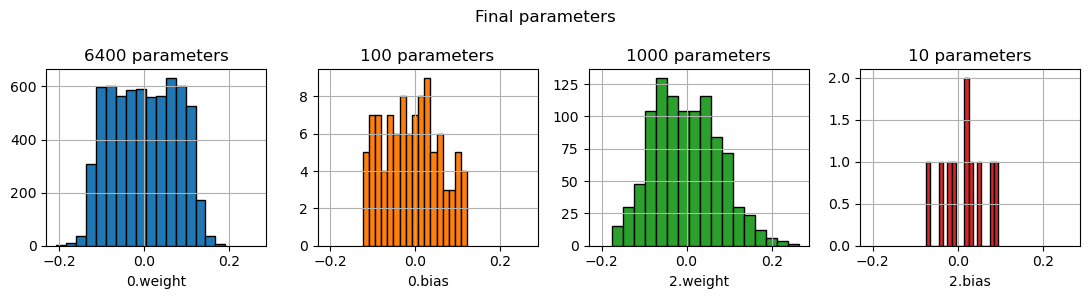

In [11]:
plt.figure(figsize=(12,3))
plt.semilogy(loss_train_augmented, label='Training augmented')
plt.plot(loss_validation, label='Validation')
plt.plot(loss_train_vanilla, label='Training vanilla')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('')
plt.grid(which='both')
plt.tight_layout()

fig,axs = plt.subplots(1,4,sharex='all',figsize=(11,3))
for i,((par_name,par),ax) in enumerate(zip(mlp.named_parameters(),axs.flat)):
    ax.hist(par.detach().cpu().ravel(),bins=17,color='C'+str(i),edgecolor='k')
    ax.set_title(f'{par.numel()} parameters')
    ax.set_xlabel(par_name)
    ax.grid()
fig.suptitle('Final parameters')
fig.tight_layout()

## Data augmentation

ML models tend to **generalize** better when trained on more diverse examples. However, it is not always feasible to get more training data, either because data is not available, or, more commonly, available data is not labeled. Strategies which we can use to diversify the used training data include generating **synthetic data** from scratch and modifying existing training data, called **data augmentation**.

Common augmentation techniques include **noise injection**, **geometric transformations** (mirroring, rotating, deforming images, etc), **frequency filtering**, **color transformations**, among others. The choice of data augmentation strategies is heavily domain specific, and must be carefully guided by the **domain expert** to ensure training data diversity while still closely matching real world data.

As an example, mirroring, rotating and flipping medical microscopy images upside down are all valid data augmentation strategies. However, for seismic images, only mirroring and small rotations would still look like real world data.

### Model performance on the training set

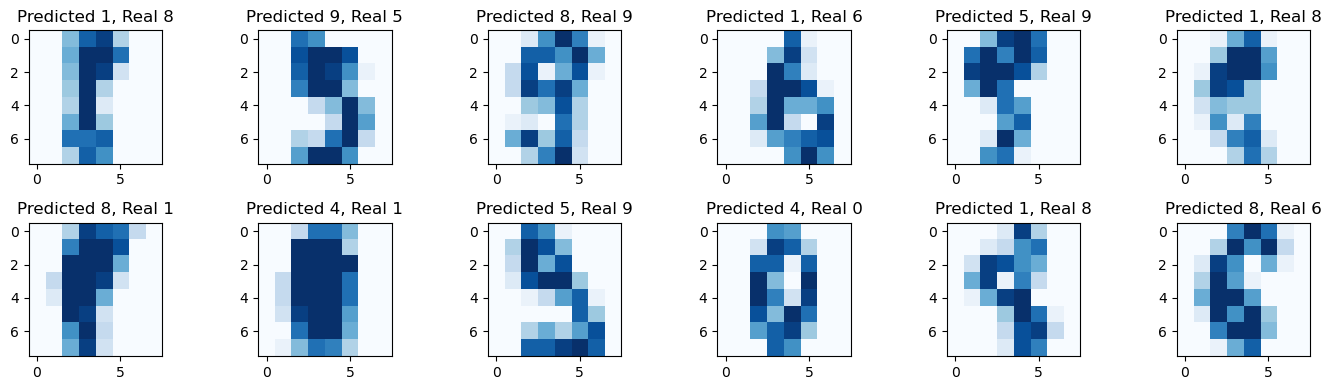

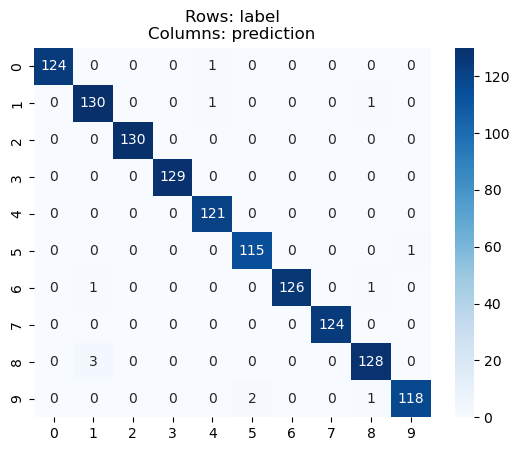

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       125
           1       0.97      0.98      0.98       132
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       129
           4       0.98      1.00      0.99       121
           5       0.98      0.99      0.99       116
           6       1.00      0.98      0.99       128
           7       1.00      1.00      1.00       124
           8       0.98      0.98      0.98       131
           9       0.99      0.98      0.98       121

    accuracy                           0.99      1257
   macro avg       0.99      0.99      0.99      1257
weighted avg       0.99      0.99      0.99      1257



In [17]:
logits_pred = mlp(X_train) # estimated class logits for the TRAINING set

y_pred = torch.argmax(logits_pred, axis=1) # most likely class for each example
labels = np.arange(logits_pred.shape[-1]) # class sequence

def show_perf(X,y,y_pred,cmap='gray_r'):
    mask = y_pred != y
    y_err  = y_pred[mask] # incorrect predictions
    yr_err = y[mask] # true values of incorrect predictions
    X_err  = X[mask] # incorrect predictions image
    
    n_wrong = X_err.shape[0]
    if n_wrong:
        ncol = min(n_wrong,6)
        nrow = int(np.ceil(n_wrong/ncol))
        fig,axs = plt.subplots(nrow,ncol,figsize=(14,2*nrow))
        [ax.remove() for ax in axs.flat[n_wrong:]]
        for xx,yy,yyr,ax in zip(X_err,y_err,yr_err,axs.flat):
            ax.imshow(xx.cpu().reshape(8,8),cmap=cmap)
            ax.set_title(f'Predicted {yy}, Real {yyr}')
        fig.tight_layout()
    plt.figure()
    cm = skm.confusion_matrix(y.cpu(), y_pred.cpu())
    sns.heatmap(cm, annot=cm, cmap=cmap, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title('Rows: label\nColumns: prediction')
    plt.show()

    crep = skm.classification_report(y.cpu(), y_pred.cpu(), zero_division=0)
    print(crep)
show_perf(X_train,y_train,y_pred,cmap='Blues')    

### Model evaluation on the validation set

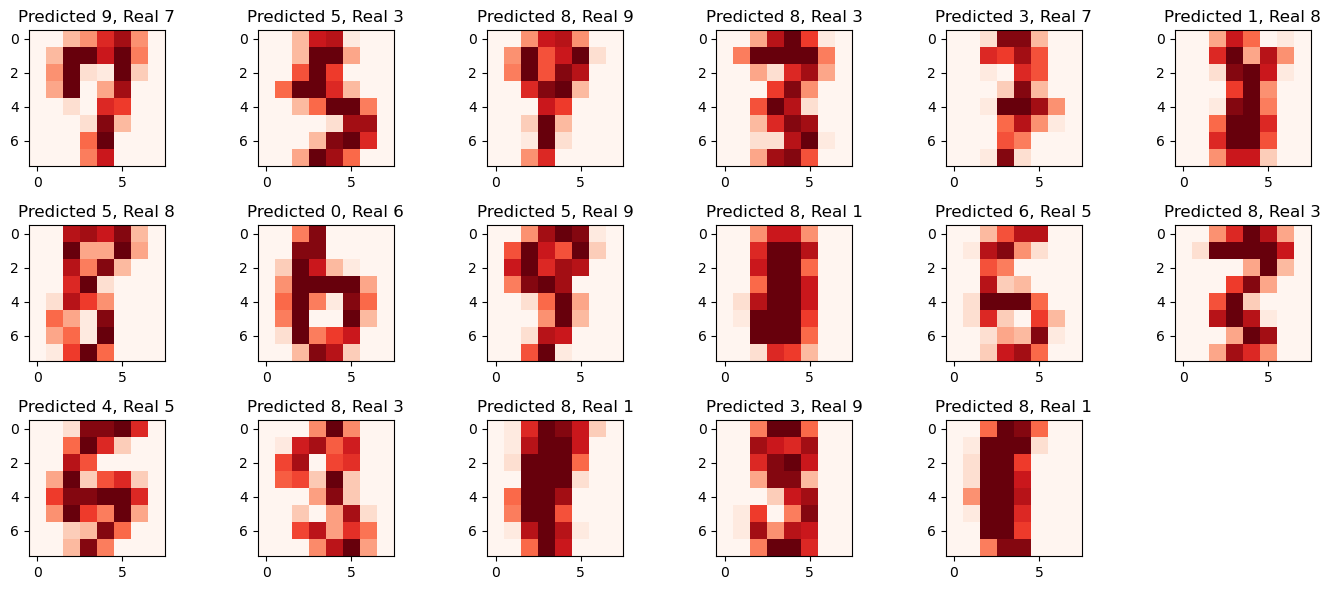

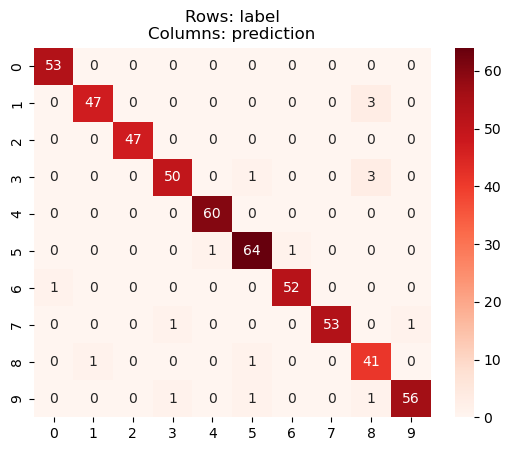

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       0.98      0.94      0.96        50
           2       1.00      1.00      1.00        47
           3       0.96      0.93      0.94        54
           4       0.98      1.00      0.99        60
           5       0.96      0.97      0.96        66
           6       0.98      0.98      0.98        53
           7       1.00      0.96      0.98        55
           8       0.85      0.95      0.90        43
           9       0.98      0.95      0.97        59

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



In [18]:
logits_pred = mlp(X_validation) # YOUR CODE HERE for estimated logits on the VALIDATION set

y_pred = torch.argmax(logits_pred, axis=1) # YOUR CODE HERE for the most likely class for each example

show_perf(X_validation,y_validation,y_pred,cmap='Reds')   

### Drawing a new number for inference

0:0.2%  ;  1:0.2%  ;  2:54.4%  ;  3:32.7%  ;  4:0.0%  ;  5:0.5%  ;  6:0.0%  ;  7:7.9%  ;  8:0.9%  ;  9:3.2%  ;  

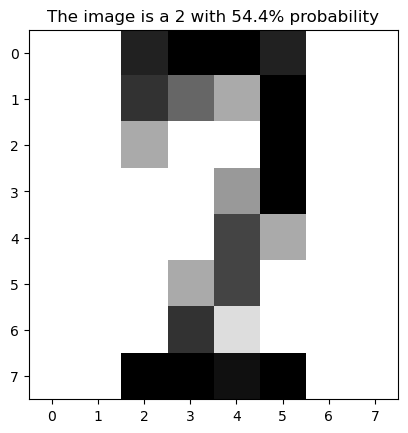

In [14]:
# Draw a digit here, with intensities between 0 and 15
my_num = torch.tensor([ 00., 00., 13., 15., 15., 13., 00.,  00.,
                        00., 00., 12., 09., 05., 15., 00.,  00.,
                        00., 00., 05., 00., 00., 15., 00.,  00.,
                        00., 00., 00., 00., 06., 15., 00.,  00.,
                        00., 00., 00., 00., 11., 05., 00.,  00.,
                        00., 00., 00., 05., 11., 00., 00.,  00.,
                        00., 00., 00., 12., 02., 00., 00.,  00.,
                        00., 00., 15., 15., 14., 15., 00.,  00.,],device=device,dtype=X_train.dtype) # YOUR CODE HERE to draw a number
my_pred = torch.softmax(mlp(my_num),-1)
for i,p in enumerate(my_pred):
    print(f'{i}:{p.item():.1%}',sep='',end='  ;  ') # printing the estimated probabilities
plt.imshow(my_num.cpu().detach().reshape(8,8),cmap='gray_r')
plt.title(f'The image is a {torch.argmax(my_pred)} with {my_pred.max():.1%} probability')
plt.show()
